In [1]:
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.constants import k as k_B  # Boltzmann constant in J/K
from scipy.constants import G, proton_mass
from functools import partial
# from lab_functions_1 import Ax, vcgrab, Tc, Lambdacalc, dLdTfunc, dVcdrfunc
import lab_functions_1 as lf

In [2]:
import importlib
import lab_functions_1  # import the full module
importlib.reload(lab_functions_1)  # reload to pick up any recent changes

# Now import the specific functions from the freshly reloaded module
import lab_functions_1 as lf

In [2]:
mp_g = proton_mass*1e3
k_Bcgs = k_B*1e7
mu = 0.6
gamma = 5/3
ktc = 3.0857e21
epsilon = 1e-3
def quadsolver(T):
    dLdT = lf.dLdTfunc(T)
    dVcdr = lf.dVcdrfunc(1*ktc, 27.1*ktc, 210*ktc)
    beta = (-5/12) + (1/6)*dLdT
    delta = (1/3)*dVcdr - 0.25
    discrim = (beta**2) - (4*delta)
    if discrim < 0:
        print("Discriminant is negative, returning NaN")
        return np.nan

    i = -beta + np.sqrt(discrim)
    j = -beta - np.sqrt(discrim)

    dlnT1 = i/2
    dlnT2 = j/2

    T1 = T*(1 + epsilon*dlnT1)
    V_base = np.sqrt(gamma * k_Bcgs * T / (mu * mp_g))
    dlnv1 = (-3/2)*dlnT1 + 3 - (2.5*(lf.Tc(ktc, 27.1*ktc, 210*ktc) / T1))
    V1 = V_base*(1 + epsilon*dlnv1)
    mach1 = V1 / np.sqrt(gamma * k_Bcgs * T1 / (mu * mp_g))

    T2 = T*(1 + epsilon*dlnT2)
    dlnv2 = (-3/2)*dlnT2 + 3 - (2.5*(lf.Tc(ktc, 27.1*ktc, 210*ktc) / T2))
    V2 = V_base*(1 + epsilon*dlnv2)
    mach2 = V2 / np.sqrt(gamma * k_Bcgs * T2 / (mu * mp_g))

    # Pick root that yields smaller Mach number
    if mach1 < mach2:
        Tnaught, vnaught = T1, V1
        machnaught = mach1
        dlnT = dlnT1
        dlnv = dlnv1
    else:
        Tnaught, vnaught = T2, V2
        machnaught = mach2
        dlnT = dlnT2
        dlnv = dlnv2

    rho1 = (3 * (mu**2) * (mp_g**2) * (lf.vcgrab(1*ktc, 27.1*ktc, 210*ktc)**3)) / (2 * lf.Lambdacalc(Tnaught) * ktc)
    Rnaught = ktc * (1 + epsilon)
    rhonaught = rho1 * (1 + epsilon * (-2 - dlnv))

    Mdot = 4 * np.pi * (Rnaught**2) * rhonaught * vnaught
    cs_naught = np.sqrt(gamma * k_Bcgs * Tnaught / (mu * mp_g))

    return Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, Mdot
print(quadsolver(1e5))

(np.float64(100086.29402628451), np.float64(4431957.491580886), 3.0887856999999996e+21, np.float64(1.3793321913178256e-26), np.float64(4790477.475465193), np.float64(0.9251598643933729), np.float64(7.329087021758814e+24))


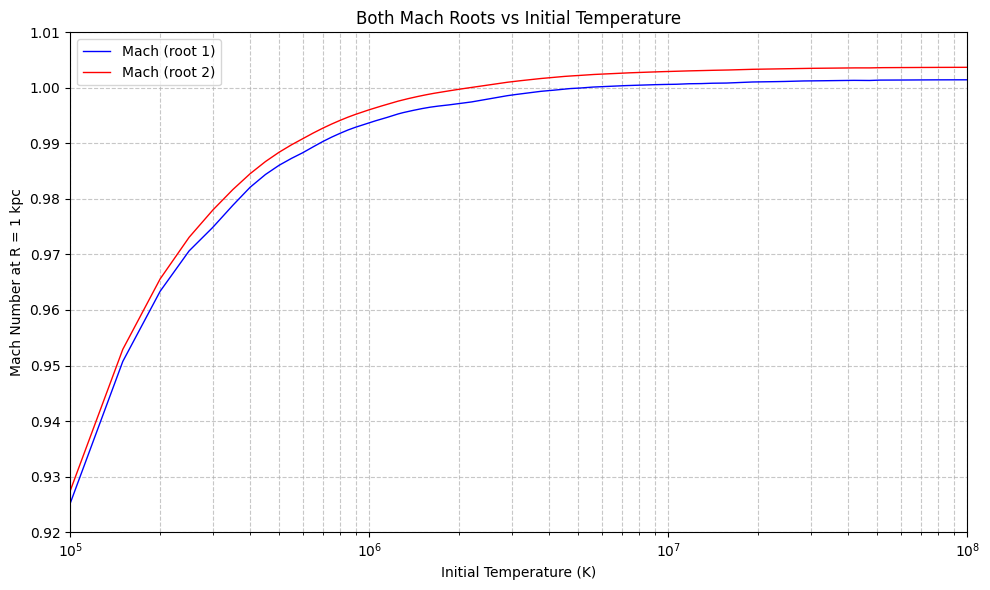

In [3]:
T_vals = np.linspace(1e5, 1e8, 2000)
mach_list = []
mach1_list = []
mach2_list = []
T_used = []
chosen_root = []

for T_try in T_vals:
    Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, Mdot = quadsolver(T_try)
    mach_list.append(machnaught)
    T_used.append(Tnaught)
    
    # Recompute both roots
    dLdT = lf.dLdTfunc(T_try)
    dVcdr = lf.dVcdrfunc(1*ktc, 27.1*ktc, 210*ktc)
    beta = (-5/12) + (1/6)*dLdT
    delta = (1/3)*dVcdr - 0.25
    discrim = (beta**2) - (4*delta)
    i = -beta + np.sqrt(discrim)
    j = -beta - np.sqrt(discrim)
    dlnT1 = i/2
    dlnT2 = j/2

    T1 = T_try * (1 + epsilon * dlnT1)
    T2 = T_try * (1 + epsilon * dlnT2)
    V_base = np.sqrt(gamma * k_Bcgs * T_try / (mu * mp_g))
    dlnv1 = (-3/2)*dlnT1 + 3 - (2.5*(lf.Tc(ktc, 27.1*ktc, 210*ktc) / T1))
    dlnv2 = (-3/2)*dlnT2 + 3 - (2.5*(lf.Tc(ktc, 27.1*ktc, 210*ktc) / T2))
    V1 = V_base * (1 + epsilon*dlnv1)
    V2 = V_base * (1 + epsilon*dlnv2)
    mach1 = V1 / np.sqrt(gamma * k_Bcgs * T1 / (mu * mp_g))
    mach2 = V2 / np.sqrt(gamma * k_Bcgs * T2 / (mu * mp_g))

    mach1_list.append(mach1)
    mach2_list.append(mach2)

    if mach1 < mach2:
        chosen_root.append(1)
    else:
        chosen_root.append(2)

# Plotting
plt.figure(figsize=(10,6))

# Plot both roots as separate lines
plt.plot(T_vals, mach1_list, color='blue', label='Mach (root 1)', linewidth=1)
plt.plot(T_vals, mach2_list, color='red', label='Mach (root 2)', linewidth=1)

plt.xlabel('Initial Temperature (K)')
plt.xscale('log')
plt.ylim(.92,1.01)
plt.xlim(1e5, 1e8)
plt.ylabel('Mach Number at R = 1 kpc')
plt.title('Both Mach Roots vs Initial Temperature')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
def vc2grab(r,rs,R):
    vc2 = lf.vcgrab(r, rs,R)**2
    return vc2/r #cm/s^2

radii = np.linspace(0.01*ktc, 1000*ktc, 4000)

In [5]:
from scipy.integrate import cumulative_trapezoid

r_grid = np.linspace(ktc, 1000000 * ktc, 5000000)  # finer grid = better accuracy
vc2_over_r = np.array([vc2grab(r, 27.1 * ktc, 210 * ktc) for r in r_grid])

phi_cumint = cumulative_trapezoid(vc2_over_r, r_grid, initial=0.0)

phi_values = -(phi_cumint[-1] - phi_cumint)

phi_interp = interp1d(r_grid, phi_values, kind='cubic', fill_value="extrapolate")

def phi(r):
    """Interpolated gravitational potential at any r."""
    return phi_interp(r)


In [35]:
vccsa = []
tftcga = []
mach21a = []
dlnvdlnr1 = []

tftca = []
dlnvdlnr2 = []

dlnTdlnra = []

ra = []
def TheBigOne(r, C, Mdot):
    v, T = C
    T = np.clip(T, 1.585e4, 1.445e8)
    
    vc2 = lf.vcgrab(r, 27.1*ktc, 210*ktc)**2
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    
    tflow = r / np.abs(v)
    mach = v / np.sqrt(cs2)
    
    Lambda = lf.Lambdacalc(T)
    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    
    tcool = (3 * k_Bcgs * T) / (2 * Lambda * n)
    
    dlnvdlnr = (2 - (vc2 / cs2) - (tflow / (gamma * tcool))) / (mach**2 - 1)
    dlnTdlnr = (tflow / tcool) - (2/3) * (2 + dlnvdlnr)
    
    dvdr = (v / r) * dlnvdlnr
    dTdr = (T / r) * dlnTdlnr
    
    # --- Diagnostic arrays ---
    ra.append(r)
    vccsa.append(2 - (vc2 / (2 * cs2)))
    tftcga.append(-tflow / (gamma * tcool))
    mach21a.append(mach**2 - 1)
    dlnvdlnr1.append(dlnvdlnr)
    dlnvdlnr2.append((-2/3) * dlnvdlnr)
    tftca.append(tflow / tcool - (4/3))
    dlnTdlnra.append(dlnTdlnr)
    
    # --- Single warning if Mach > 1 ---
    if mach > 1.0:
        print(f"WARNING: Mach = {mach:.3f} at r = {r:.3e} cm → is supersonic!")
    
    return [dvdr, dTdr]

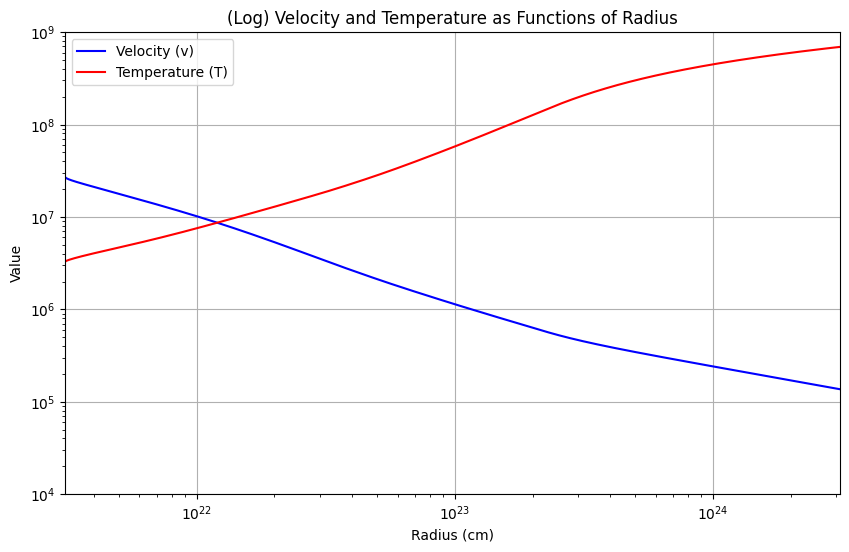

In [36]:
TVAL = 3.25e6
def TtoSet(T):
    Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, _ = quadsolver(T)
    C0 = [vnaught, Tnaught]
    Mdot = 4 * np.pi * (Rnaught**2) * rhonaught * vnaught

    r_start = Rnaught
    r_end = 1000*ktc
    r_eval = np.logspace(np.log10(r_start), np.log10(r_end), 10000)
    r_eval = r_eval[(r_eval >= r_start) & (r_eval <= r_end)]

    TheBigOne_with_Mdot = partial(TheBigOne, Mdot=Mdot)

    sol = solve_ivp(TheBigOne_with_Mdot, [r_start, r_end], C0, t_eval=r_eval,
                    method='DOP853', atol=1e-6, rtol=1e-6, dense_output=True)
    return sol.t, sol.y[0], sol.y[1]
sol_t, v_sol, T_sol = TtoSet(TVAL)
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sol_t, v_sol, label='Velocity (v)', color='blue')
plt.plot(sol_t, T_sol, label='Temperature (T)', color='red')
plt.xlabel('Radius (cm)')
plt.ylabel('Value')
plt.xscale('log')
plt.yscale('log')
plt.title('(Log) Velocity and Temperature as Functions of Radius')
plt.legend()
plt.grid(True)
plt.xlim(3.08e21, 3.09e24)
plt.ylim(1e4, 1e9)
plt.savefig('velocity_and_temperature_log_plot.png', transparent=True)
plt.show()

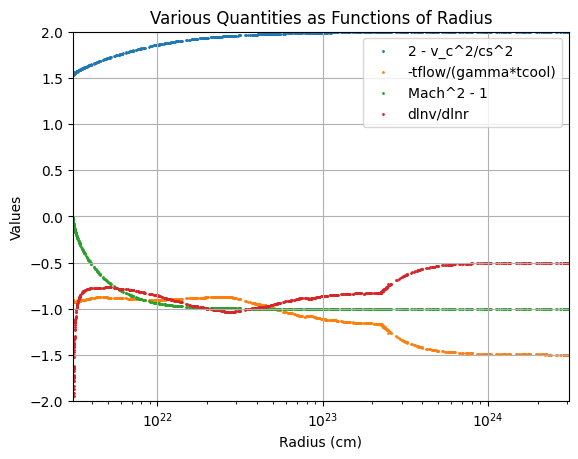

In [37]:
plt.scatter(ra, vccsa, s=1, label='2 - v_c^2/cs^2')
plt.scatter(ra, tftcga, s=1, label='-tflow/(gamma*tcool)')
plt.scatter(ra, mach21a, s=1, label='Mach^2 - 1')
plt.scatter(ra, dlnvdlnr1, s=1, label='dlnv/dlnr')
plt.xlabel('Radius (cm)')
plt.ylabel('Values')
plt.xscale('log')
#plt.yscale('log')
plt.title('Various Quantities as Functions of Radius')
plt.legend()
plt.xlim(3.086e21, 3.086e24)
plt.ylim(-2, 2)
plt.grid(True)
plt.savefig('dlnvdlnr components.png', transparent=True)
plt.show()

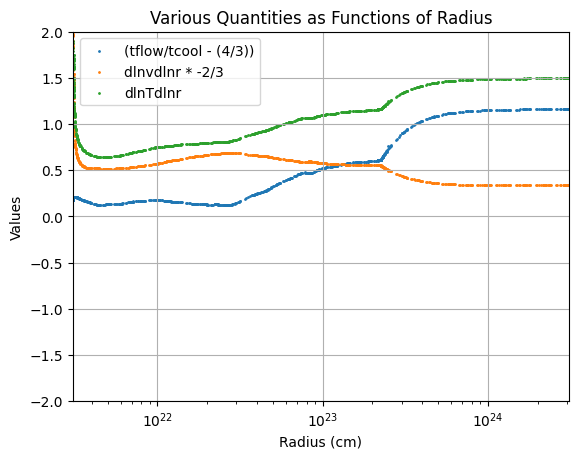

In [38]:
plt.scatter(ra, tftca, s=1, label='(tflow/tcool - (4/3))')
plt.scatter(ra, dlnvdlnr2, s=1, label='dlnvdlnr * -2/3')
plt.scatter(ra, dlnTdlnra, s=1, label='dlnTdlnr')
plt.xlabel('Radius (cm)')
plt.ylabel('Values')
plt.xscale('log')
#plt.yscale('log')
plt.title('Various Quantities as Functions of Radius')
plt.legend()
plt.xlim(3.08e21, 3.09e24)
plt.ylim(-2, 2)
plt.grid(True)
plt.savefig('dlnTdlnr_components.png', transparent=True)
plt.show()

In [39]:
Tvalarray = np.arange(4.20, 8.20, 0.04)
Lambdavalarray = np.array(
    [-21.6114, -21.4833, -21.5129, -21.5974, -21.6878, -21.7659, -21.8092, -21.8230, -21.8059, -21.7621, -21.6941,
    -21.6111, -21.5286, -21.4387, -21.3589, -21.2816, -21.2168, -21.1700, -21.1423, -21.1331, -21.1525, -21.1820,
    -21.2077, -21.2093, -21.2043, -21.1937, -21.1832, -21.1811, -21.1799, -21.1883, -21.2263, -21.3118, -21.4700,
    -21.6521, -21.7926, -21.8728, -21.9090, -21.9290, -21.9539, -22.0008, -22.0678, -22.1209, -22.1521, -22.1698,
    -22.1804, -22.1977, -22.2178, -22.2383, -22.2459, -22.2557, -22.2736, -22.3075, -22.3657, -22.4391, -22.5207,
    -22.5909, -22.6490, -22.6878, -22.7148, -22.7308, -22.7361, -22.7379, -22.7283, -22.7216, -22.7102, -22.7023,
    -22.6962, -22.6921, -22.6959, -22.6994, -22.7050, -22.7170, -22.7249, -22.7378, -22.7480, -22.7629, -22.7710,
    -22.7697, -22.7655, -22.7605, -22.7565, -22.7461, -22.7323, -22.7176, -22.7039, -22.6873, -22.6700, -22.6613,
    -22.6436, -22.6251, -22.6071, -22.5914, -22.5727, -22.5542, -22.5360, -22.5172, -22.5014, -22.4828, -22.4642,
    -22.4455])

f_cubic = interp1d(Tvalarray, Lambdavalarray, kind='cubic')

x_fine = np.linspace(Tvalarray.min(), Tvalarray.max(), 500)
y_cubic = f_cubic(x_fine)

# Plot
# plt.figure(figsize=(10, 6))
# plt.plot(Tvalarray, Lambdavalarray, 'purple', label='Plot of log(Lambda) vs. Log(T)', color='gray')
# plt.plot(x_fine, y_cubic, '-', label='Cubic interpolation', color='purple')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Cubic Interpolation of y vs x')
# plt.grid(True)
# plt.legend()
# plt.show()

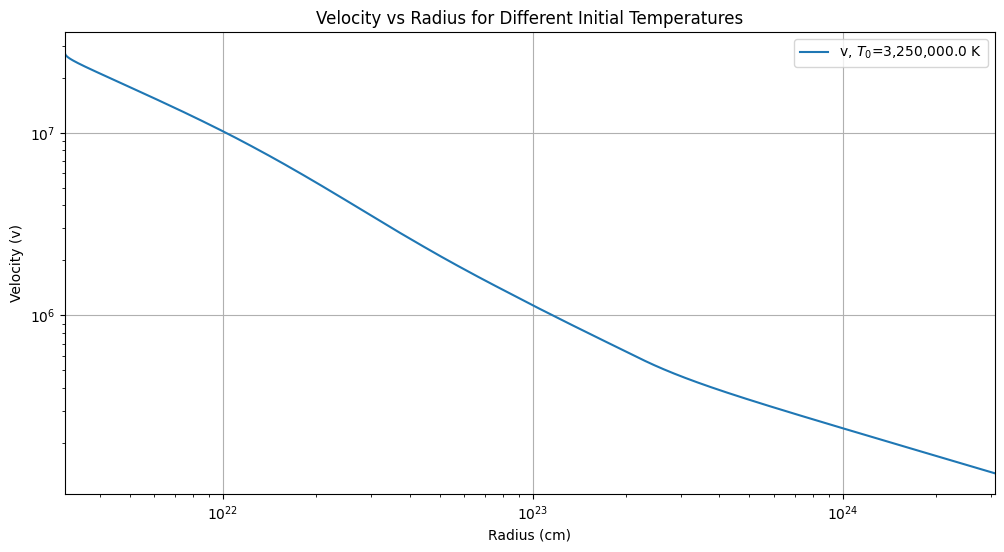

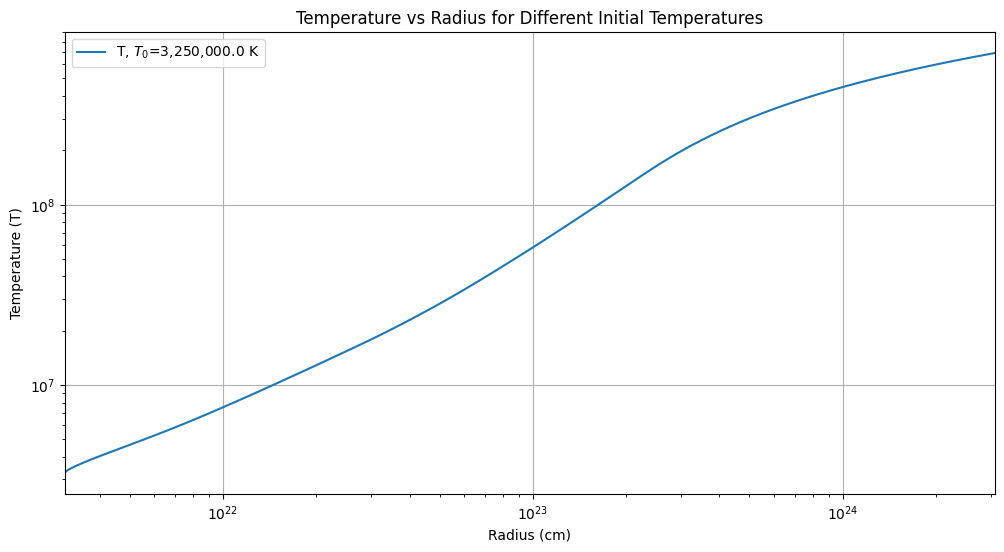

In [40]:
T_set = [TVAL]
results = []

for val in T_set:
    r, v_sol, T_sol = TtoSet(val)
    results.append({'T_init': val, 'r': r, 'v': v_sol, 'T': T_sol})

# Plotting
plt.figure(figsize=(12, 6))

# Plot velocity for each initial temperature
for res in results:
    plt.plot(res['r'], res['v'], label=f'v, $T_0$={res["T_init"]:,} K')

plt.xlabel('Radius (cm)')
plt.ylabel('Velocity (v)')
plt.xscale('log')
plt.yscale('log')
plt.title('Velocity vs Radius for Different Initial Temperatures')
plt.legend()
plt.grid(True)
plt.xlim(3.08e21, 3.09e24)
#plt.savefig('velocity_comparison.png', transparent=True)
plt.show()

plt.figure(figsize=(12, 6))

# Plot temperature for each initial temperature
for res in results:
    plt.plot(res['r'], res['T'], label=f'T, $T_0$={res["T_init"]:,} K')

plt.xlabel('Radius (cm)')
plt.ylabel('Temperature (T)')
plt.xscale('log')
plt.yscale('log')
plt.title('Temperature vs Radius for Different Initial Temperatures')
plt.legend()
plt.grid(True)
plt.xlim(3.08e21, 3.09e24)
#plt.savefig('temperature_comparison.png', transparent=True)
plt.show()

C:\Users\Jacob\AppData\Local\Temp\ipykernel_6452\4282608993.py:53: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-1e14, 0)


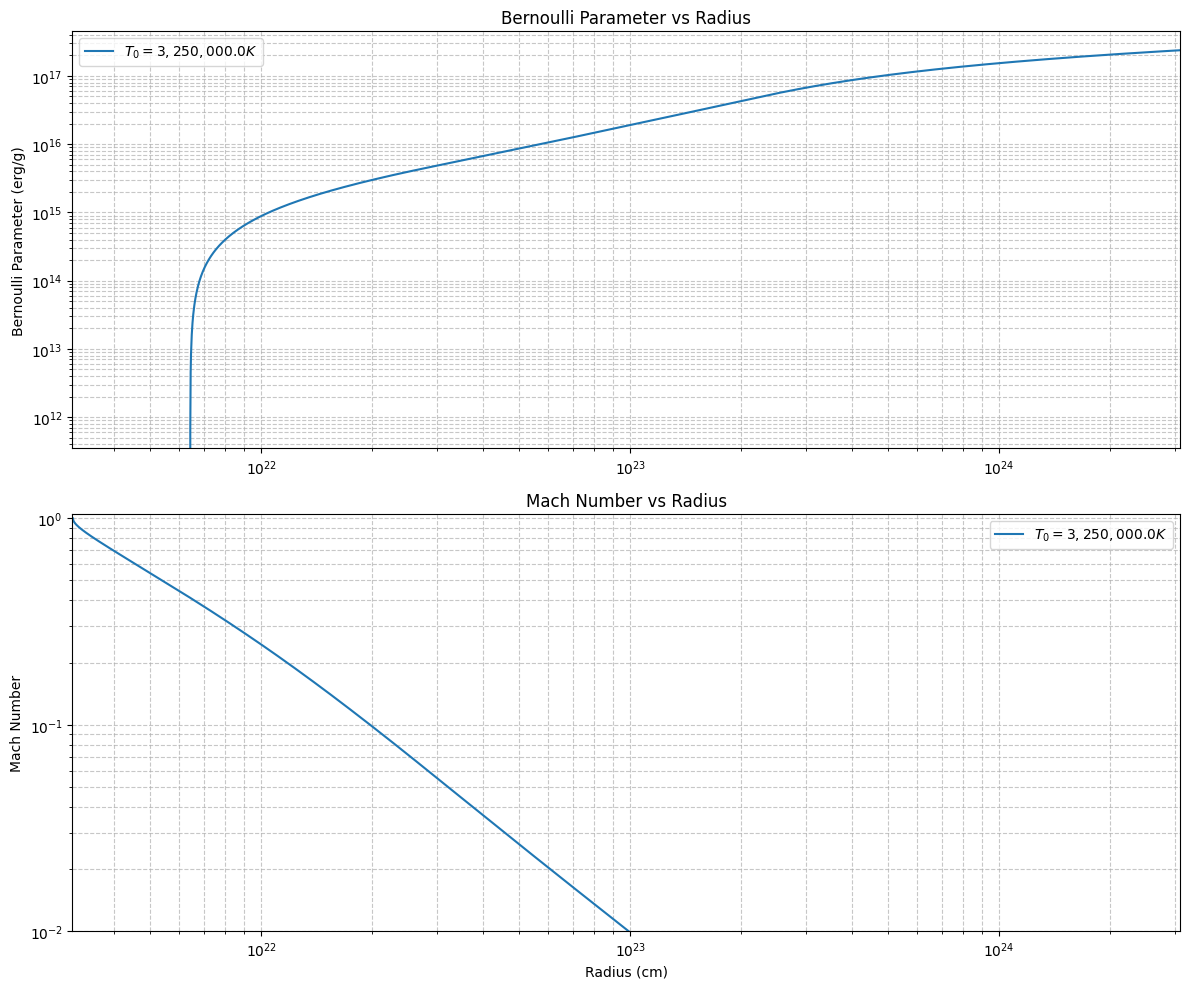

In [41]:
def TtoSet_Bern(T):
    Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, _ = quadsolver(T)
    C0 = [vnaught, Tnaught]
    Mdot = 4 * np.pi * (Rnaught**2) * rhonaught * vnaught

    r_start = Rnaught
    r_end = 1000 * ktc
    r_eval = np.logspace(np.log10(r_start), np.log10(r_end), 3000)
    r_eval = r_eval[(r_eval >= r_start) & (r_eval <= r_end)]

    TheBigOne_with_Mdot = partial(TheBigOne, Mdot=Mdot)

    sol = solve_ivp(TheBigOne_with_Mdot, [r_start, r_end], C0, t_eval=r_eval,
                    method='DOP853', atol=1e-5, rtol=1e-5, dense_output=True)

    v_arr = sol.y[0]
    T_arr = sol.y[1]
    Bern_arr = []
    for r, v, T in zip(sol.t, v_arr, T_arr):
        cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
        Bern = (v**2 / 2) + (cs2 * 3 / 2) + phi(r)
        Bern_arr.append(Bern)
    return sol.t, v_arr, T_arr, np.array(Bern_arr)


T_set = [TVAL]
results = []

for val in T_set:
    r, v_sol, T_sol, Bern_arr = TtoSet_Bern(val)
    results.append({'T_init': val, 'r': r, 'v': v_sol, 'T': T_sol, 'Bern': Bern_arr})

plt.figure(figsize=(12, 10))

for res in results:
    # Mach number calculation
    cs_arr = np.sqrt((gamma * k_Bcgs * res['T']) / (mu * mp_g))
    Mach_arr = res['v'] / cs_arr

    # Bernoulli plot (top)
    plt.subplot(2, 1, 1)
    plt.plot(res['r'], res['Bern'], label=f'$T_0={res["T_init"]:,} K$')

    # Mach plot (bottom)
    plt.subplot(2, 1, 2)
    plt.plot(res['r'], Mach_arr, label=f'$T_0={res["T_init"]:,} K$')

# Bernoulli plot
plt.subplot(2, 1, 1)
plt.xscale('log')
plt.xlim(3.08e21, 3.09e24)
plt.yscale('log')
plt.ylim(-1e14, 0)
plt.ylabel('Bernoulli Parameter (erg/g)')
plt.title('Bernoulli Parameter vs Radius')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()

# Mach plot
plt.subplot(2, 1, 2)
plt.xscale('log')
plt.xlim(3.08e21, 3.09e24)
plt.xlabel('Radius (cm)')
plt.ylabel('Mach Number')
plt.ylim(0.01, None)
plt.yscale('log')
plt.title('Mach Number vs Radius')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('bern_mach_multiplot.png', transparent=True)
plt.show()

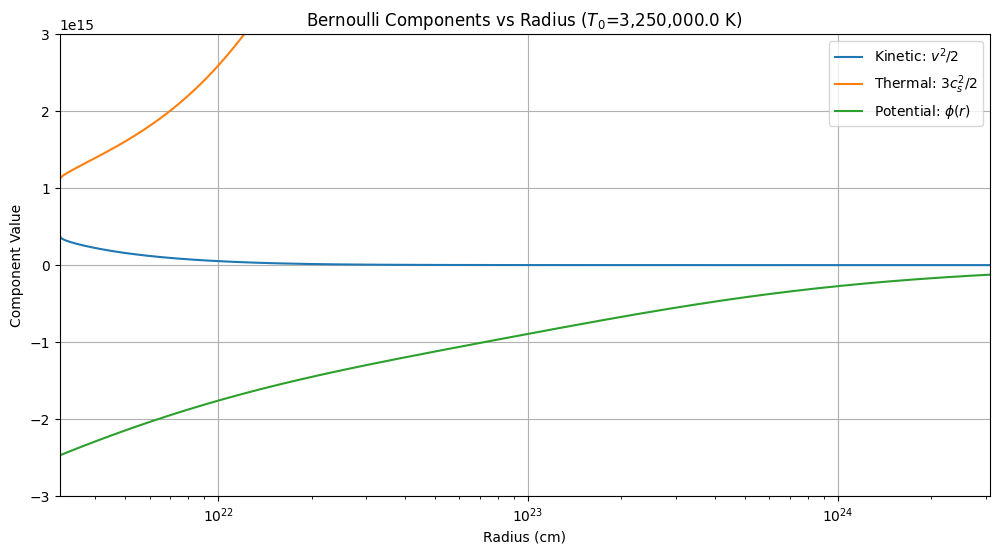

None


In [42]:
def plot_bernoulli_components(T, r_points=3000):
    # Get initial conditions
    Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, _ = quadsolver(T)
    C0 = [vnaught, Tnaught]
    Mdot = 4 * np.pi * (Rnaught**2) * rhonaught * vnaught

    r_start = Rnaught
    r_end = 1000 * ktc
    r_eval = np.logspace(np.log10(r_start), np.log10(r_end), r_points)
    r_eval = r_eval[(r_eval >= r_start) & (r_eval <= r_end)]

    TheBigOne_with_Mdot = partial(TheBigOne, Mdot=Mdot)

    sol = solve_ivp(TheBigOne_with_Mdot, [r_start, r_end], C0, t_eval=r_eval,
                    method='DOP853', atol=1e-5, rtol=1e-5, dense_output=True)

    v_arr = sol.y[0]
    T_arr = sol.y[1]
    r_arr = sol.t
    kin_arr = 0.5 * v_arr**2
    cs2_arr = (gamma * k_Bcgs * T_arr) / (mu * mp_g)
    therm_arr = 1.5 * cs2_arr
    phi_arr = np.array([phi(r) for r in r_arr])

    plt.figure(figsize=(12, 6))
    plt.plot(r_arr, kin_arr, label=r'Kinetic: $v^2/2$')
    plt.plot(r_arr, therm_arr, label=r'Thermal: $3c_s^2/2$')
    plt.plot(r_arr, phi_arr, label=r'Potential: $\phi(r)$')
    plt.xlabel('Radius (cm)')
    plt.ylabel('Component Value')
    plt.xscale('log')
    #plt.yscale('log')
    plt.title(f'Bernoulli Components vs Radius ($T_0$={T:,} K)')
    plt.legend()
    plt.grid(True)
    plt.xlim(3.08e21, 3.09e24)
    plt.ylim(-3e15, 3e15)
    plt.savefig(f'bernoulli_components_.png', transparent=True)
    plt.show()
    
# Example usage:
print(plot_bernoulli_components(TVAL))

In [14]:
def rhocalc(v, tftc, T, r):
    gamma = 5/3
    nset = 10**np.arange(-7, 10, 0.01)
    rhoset = nset*mp_g
    Pset = nset * k_Bcgs * T
    tcoolset = (Pset/(gamma/(gamma-1)) / (nset**2 * lf.Lambdacalc(T)))
    vset = (r / (tcoolset * tftc))

    lv = np.log(v)
    lvs = np.log(vset)
    arr = lvs - lv
    inds = ((np.sign(arr[1:]) * np.sign(arr[:-1])) < 0).nonzero()[0]
    if len(inds)!=1: return False
    ind = inds[0]
    log_rhoset = np.log(rhoset)
    if vset[ind]<vset[ind+1]: 
        good_lrho = np.interp(lv, lvs[ind:ind+2], log_rhoset[ind:ind+2]) 
    else:
        good_lrho = np.interp(lv, lvs[ind+1:ind-1:-1], log_rhoset[ind+1:ind-1:-1]) 
    return 10.**good_lrho

In [22]:
def dlnTdlnrcalc(R_sonic, x, T_sonic_point,pr=True): 
 
    dlnLambda_dlnT = lf.Lambdacalc(T_sonic_point)
    dlnvc_dlnR = lf.dVcdrfunc(R_sonic, 27.1*ktc, 210*ktc)
    
    #solve quadratic equation    
    b = 29/6.*x - 17/6. + 1/3.*(1.-x)*(dlnLambda_dlnT)
    c = 2/3.*x*dlnvc_dlnR + 5*x**2 - 13/3.*x + 2/3.
    if b**2-4*c >= 0:
        return [(-b +j * (b**2-4*c)**0.5)/2. for j in (-1,1)]
    else:
        if pr: print('no transsonic solutions')
        return None, None

In [49]:
# CLASSES (THE BANE OF MY EXISTENCE)
class IntegrationResult:
    def __init__(self, res, stop_reason):
        self.res = res
        self._stop_reason = stop_reason
    
    def stopReason(self):
        return self._stop_reason
    
    def Rs(self):
        return self.res.t
    
    def __getitem__(self, key):
        return self.res[key]


# THE ODE SOLVER ITSELF
def TheODE(r, C, Mdot):
    v, T = C
    T = np.clip(T, 1.585e4, 1.445e8)
    
    vc2 = lf.vcgrab(r, 27.1*ktc, 210*ktc)**2
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    
    tflow = r / np.abs(v)
    mach = v / np.sqrt(cs2)
    
    Lambda = lf.Lambdacalc(T)
    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    
    tcool = (3 * k_Bcgs * T) / (2 * Lambda * n)

    dlnvdlnr = (2 - (vc2 / cs2) - (tflow/ (gamma*tcool))) / (mach**2 - 1.0)
    dlnTdlnr = (tflow / tcool) - (2/3) * (2 + dlnvdlnr)
    
    dvdr = (v / r) * dlnvdlnr
    dTdr = (T / r) * dlnTdlnr
    
    if mach > 1.0:
        print(f"WARNING: Mach = {mach:.3f} at r = {r:.3e} cm → is supersonic!")
    
    return [dvdr, dTdr]


# EVENTS LIST
def event_unbound(r, C, Mdot):
    v, T = C
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    phi_r = phi(r)
    bern = 0.5 * v**2 + 1.5 * cs2 + phi_r
    return bern
event_unbound.terminal = True
event_unbound.direction = 1

def event_lowT(r, C, Mdot):
    T = C[1]
    return T - (10**4.2)
event_lowT.terminal = True
event_lowT.direction = -1 

def event_sonic_point(r, C, Mdot):
    v, T = C
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    mach = v / np.sqrt(cs2)
    return mach - 1.0
event_sonic_point.terminal = True
event_sonic_point.direction = -1

def event_max_R(r, C, Mdot):
    v, T = C
    return r - (2100*ktc)
event_max_R.terminal = True
event_max_R.direction = 1

my_event_list = [
    event_sonic_point,
    event_unbound,
    event_lowT,
    event_max_R
]


event_names = ['sonic point', 'unbound', 'lowT', 'max R reached']

# SHOOTING METHOD
def sonic_point_shooting(tol, Rsonic, Rmax, epsilon, dlnMdlnRInit=-1, x_high=0.95, x_low=1e-5, return_all_results=False):
    results = {}
    dlnMdlnRold = dlnMdlnRInit
    
    while x_high - x_low > tol:
        x = 0.5 * (x_high + x_low)
        cs2_sonic = lf.vcgrab(Rsonic, 27.1*ktc, 210*ktc)**2 / (2 * x)
        v_sonic = cs2_sonic**0.5
        T_sonic = mu * mp_g * cs2_sonic / (gamma * k_Bcgs)
        tflow_to_tcool = (10/3) * (1 - x)
        
        rho_sonic = rhocalc(v_sonic, tflow_to_tcool, T_sonic, Rsonic)
        if rho_sonic == False:
            x_high = x
            continue
        
        Mdot = 4 * np.pi * Rsonic**2 * rho_sonic * v_sonic
        
        dlnTdlnR1, dlnTdlnR2 = dlnTdlnrcalc(Rsonic, x, T_sonic, pr=True)
        if dlnTdlnR1 is None:
            x_high = x
            continue
        
        dlnMdlnR1, dlnMdlnR2 = [3 - 5*x - 2*dlnTdlnR for dlnTdlnR in (dlnTdlnR1, dlnTdlnR2)]
        if abs(dlnMdlnR1 - dlnMdlnRold) < abs(dlnMdlnR2 - dlnMdlnRold):
            dlnTdlnR = dlnTdlnR1
        else:
            dlnTdlnR = dlnTdlnR2
        
        dlnMdlnR = 3 - 5*x - 2*dlnTdlnR
        
        dlnvdlnR = -1.5 * dlnTdlnR + 3 - 5 * x
        dlnrhodlnR = -dlnvdlnR - 2
        
        T0 = T_sonic * (1 + epsilon * dlnTdlnR)
        v0 = v_sonic * (1 + epsilon * dlnvdlnR)
        R0 = Rsonic * (1 + epsilon)

        print(f"T0: {T0}, v0: {v0}, R0: {R0}")

        # Early checks
        cs2_0 = (gamma * k_Bcgs * T0) / (mu * mp_g)
        mach0 = v0 / np.sqrt(cs2_0)
        if mach0 > 1.0:
            print("starts supersonic")
            x_high = x
            continue

        phi0 = phi(R0)
        bern = 0.5 * v0**2 + 1.5 * cs2_0 + phi0
        if bern > 0:
            print(f"starts unbound")
            x_low = x
            continue
        # Integration
        res_raw = solve_ivp(
            TheODE, [R0, Rmax], [v0, T0], args=(Mdot,),
            method='RK45', max_step=0.1, atol=1e-6, rtol=1e-6,
            events=my_event_list
        )

        if res_raw.status < 0:
            stop_reason = 'integration failure'
        elif any(len(evt) > 0 for evt in res_raw.t_events):
            for idx, t_evt in enumerate(res_raw.t_events):
                if len(t_evt) > 0:
                    stop_reason = event_names[idx]
                    break
        else:
            if res_raw.t[-1] >= Rmax:
                stop_reason = 'max R reached'
            else:
                stop_reason = 'unknown'
        
        res = IntegrationResult(res_raw, stop_reason)
        
        print(f"maximum r = {res.Rs()[-1] / 3.0857e21:.2f} kpc; stop reason: {res.stopReason()}")
        
        if res.stopReason() in ('sonic point', 'lowT'):
            x_high = x
            continue
        elif res.stopReason() == 'unbound':
            x_low = x
            continue
        elif res.stopReason() == 'max R reached':
            dlnMdlnRold = dlnMdlnR
            results[x] = res
            break
        else:
            print(f"Warning: Unexpected stopReason '{res.stopReason()}' — stopping loop.")
            break
    
    if return_all_results:
        return results
    if len(results) == 0:
        print("no result reached maximum R")
        return None
    else:
        return results[x]

In [50]:
result = sonic_point_shooting(
    tol=1e-5,
    Rsonic=1*ktc,
    Rmax=2100*ktc,
    epsilon=1e-5,
    return_all_results=False
)

if result is None:
    print("No solution reached max radius.")
elif isinstance(result, dict):
    for xval, res in result.items():
        print(f"x = {xval:.5f}, stop reason = {res.stopReason()}")
else:
    print(f"Stop reason: {result.stopReason()}")
    print(f"Final radius (kpc): {result.Rs()[-1] / 3.0857e21:.3f}")
    v_final, T_final = result.res.y[:, -1]
    print(f"Final velocity (cm/s): {v_final:.3e}")
    print(f"Final temperature (K): {T_final:.3e}")

T0: 3208935.083647921, v0: 27124832.47440075, R0: 3.085730857e+21
maximum r = 1.00 kpc; stop reason: integration failure
no result reached maximum R
No solution reached max radius.
